In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import sklearn
from scipy import stats
import tensorflow as tf

2023-08-04 14:54:23.443800: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
##Wavenumbers
k = 12 * np.pi
m = 6 * np.pi
m_U = 14 * np.pi #vertical wavenumber
##

r_m = 0.1
N0_squared = 100


k_e = np.sqrt(k**2 + m**2)
k_plus = np.sqrt(k**2 +(m+m_U)**2)

W_e = np.array([[-1, k / (k_e**2)],
                [-k * N0_squared, -1]])
W_plus = np.array([[-1, -k / (k_plus**2)],
                [k * N0_squared, -1]])

W = np.block([[W_e, np.zeros((2, 2))],
             [np.zeros((2, 2)), W_plus]])

L_e = np.array([[-(k*(k_plus**2 - m_U**2)) / (2 * (k_e**2)), 0],
                [0, k / 2]])

L_plus = np.array([[-(k*(m_U**2 - k_e**2)) / (2 * (k_plus**2)), 0],
                [0, -k / 2]])

L = np.block([[np.zeros((2, 2)), L_e],
             [L_plus, np.zeros((2, 2))]])

In [4]:
initial_state = np.array([[0, 0, 0, 0, 0.001]]).T  #The initial state for the y_em output where the concatenated array looks like [psi_e, b_e, psi_plus, b_plus, U]
t_span = (0, 1100)
dt = 0.001
epsilon = 0.01  #noise strength (0.01 has been well used)


#The function below uses the Euler Maruyama method which is used to solve Stochastic Differential Equations (SDEs)
def euler_maruyama(y0, t_span, dt, epsilon, noise_forcing_out):
    t0, tf = t_span
    t = np.linspace(t0, tf, int((tf - t0) / dt) + 1)
    s = np.zeros((4, len(t)))
    U = np.zeros(len(t))
    R = np.zeros(len(t))

    s[:, 0] = y0[:4].ravel()
    U[0] = y0[4]
    R[0] = 0

    for i in range(len(t) - 1):
        noise_forcing = np.sqrt(dt) * (2 * np.sqrt(2) / k_e) * noise_forcing_out[i]
        noise_forcing_vector = np.array([noise_forcing, 0, 0, 0])
        psi_e = s[0, i]
        psi_p = s[2, i]
        s[:, i + 1] = s[:, i] + dt * (W @ s[:, i] + U[i] * (L @ s[:, i])) + np.sqrt(epsilon) * noise_forcing_vector
        U[i + 1] = U[i] + dt * ((0.25 * k * (k_plus**2 - k_e**2) * psi_e * psi_p) - (r_m * U[i]))

    y = np.vstack((s, U))
    return t, y


In [5]:
def milstein(y0, t_span, dt, epsilon, noise_forcing_out):
    t0, tf = t_span
    t = np.linspace(t0, tf, int((tf - t0) / dt) + 1)
    s = np.zeros((4, len(t)))
    U = np.zeros(len(t))
    R = np.zeros(len(t))

    s[:, 0] = y0[:4].ravel()
    U[0] = y0[4]
    R[0] = 0

    for i in range(len(t) - 1):
        noise_forcing = np.sqrt(dt) * noise_forcing_out[i]
        noise_forcing_vector = np.array([noise_forcing, 0, 0, 0])
        psi_e = s[0, i]
        psi_p = s[2, i]
        drift = W @ s[:, i] + U[i] * (L @ s[:, i])
        diffusion = noise_forcing_vector
        s[:, i + 1] = s[:, i] + dt * drift + diffusion * (2 * np.sqrt(2) / k_e) * np.sqrt(epsilon) + 0.5 * (((2 * np.sqrt(2) / k_e) * np.sqrt(epsilon))**2) * (noise_forcing**2 - dt)  # Corrected Milstein term
        U[i + 1] = U[i] + dt * ((0.25 * k * (k_plus**2 - k_e**2) * psi_e * psi_p) - (r_m * U[i]))

    y = np.vstack((s, U))
    return t, y

In [6]:
t_span = (0, 500) # Time span
dt = 0.001  # Time step

t0, tf = t_span
t = np.linspace(t0, tf, int((tf - t0) / dt) + 1)
noise_forcing_out = np.random.normal(0, 1, len(t))

# noise_forcing_out = noise_forcing2[::2]


t_em, y_em = euler_maruyama(initial_state, t_span, dt, epsilon, noise_forcing_out)   # Solve the SDE
R_em = 0.25 * k * (k_plus**2 - k_e**2) * y_em[0] * y_em[2] 
U_em = y_em[4]


In [7]:
t_mil, y_mil = milstein(initial_state, t_span, dt, epsilon, noise_forcing_out)   # Solve the SDE
R_mil = 0.25 * k * (k_plus**2 - k_e**2) * y_mil[0] * y_mil[2]
U_mil = y_mil[4]

In [8]:
t_em2, y_em2 = euler_maruyama(initial_state, t_span2, dt/2, epsilon, noise_forcing_out)
U_em2 = y_em2[4]
R_em2 = 0.25 * k * (k_plus**2 - k_e**2) * y_em2[0] * y_em2[2]

Milstein (dt): Mean=0.13233378248224667, Variance=0.0017924984642301736
Milstein (dt/2): Mean=0.12009330793931397, Variance=0.0022388464967220143
Euler-Maruyama: Mean=0.13248195588901032, Variance=0.0017735483441568296
Euler-Maruyama (dt/2): Mean=0.12012377875494568, Variance=0.0022359053133932877


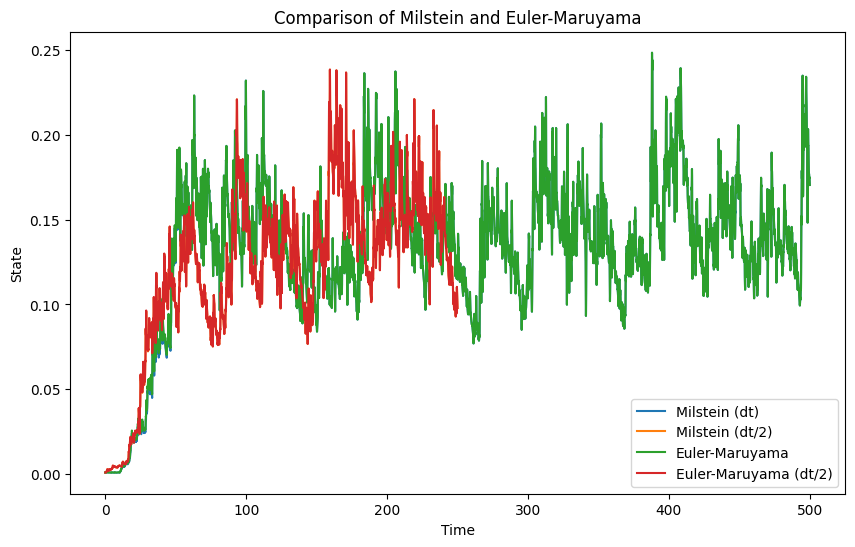

In [11]:
# Generate a smaller time step dt/2
t_span2 = (0, 250)
t_mil2, y_mil2 = milstein(initial_state, t_span2, dt/2, epsilon, noise_forcing_out)

# Calculate the mean and variance for each method
mean_mil = np.mean(y_mil[-1])
var_mil = np.var(y_mil[-1])

mean_mil2 = np.mean(y_mil2[-1])
var_mil2 = np.var(y_mil2[-1])

mean_em = np.mean(y_em[-1])
var_em = np.var(y_em[-1])

mean_em2 = np.mean(y_em2[-1])
var_em2 = np.var(y_em2[-1])

# Print the mean and variance
print(f"Milstein (dt): Mean={mean_mil}, Variance={var_mil}")
print(f"Milstein (dt/2): Mean={mean_mil2}, Variance={var_mil2}")
print(f"Euler-Maruyama: Mean={mean_em}, Variance={var_em}")
print(f"Euler-Maruyama (dt/2): Mean={mean_em2}, Variance={var_em2}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_mil, y_mil[4], label="Milstein (dt)")
plt.plot(t_mil2, y_mil2[4], label="Milstein (dt/2)")
plt.plot(t_em, y_em[4], label="Euler-Maruyama")
plt.plot(t_em2, y_em2[4], label="Euler-Maruyama (dt/2)")
plt.legend()
plt.xlabel("Time")
plt.ylabel("State")
plt.title("Comparison of Milstein and Euler-Maruyama")
plt.show()

In [72]:
U_mil2 = y_mil2[4]
R_mil2 = 0.25 * k * (k_plus**2 - k_e**2) * y_mil2[0] * y_mil2[2]

In [73]:
# save the variables as numpy .npz
# np.savez('data/milsteinmethod_21000.npz', t_em=t_em, R_em=R_em, U_em=U_em, R_mil=R_mil, U_mil=U_mil)

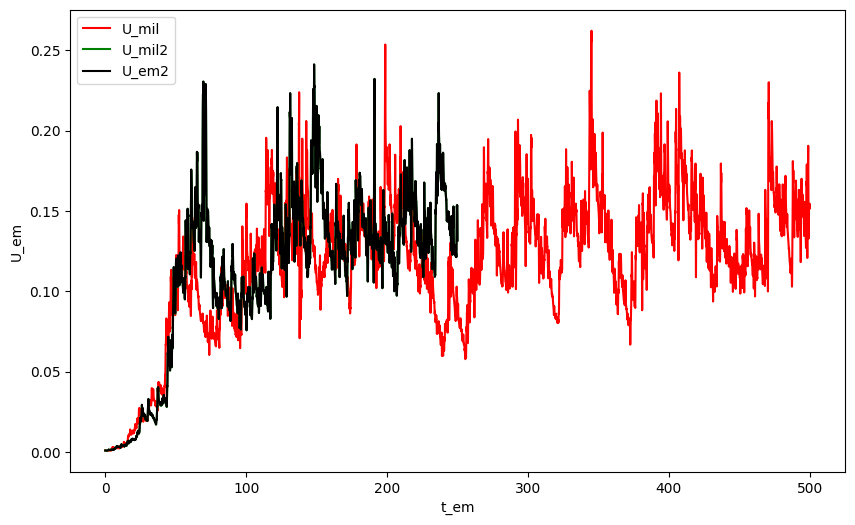

In [84]:
#plot U_em vs t_em
plt.figure(figsize=(10, 6))
# plt.plot(t_em, U_em, 'b', label='U_em')
plt.plot(t_mil, U_mil, 'r', label='U_mil')
plt.plot(t_mil2, U_mil2, 'g', label='U_mil2')
plt.plot(t_em2, U_em2, 'k', label='U_em2')
plt.xlabel('t_em')
plt.ylabel('U_em')
plt.legend(loc='best')
plt.show()


In [79]:
# print(np.mean(U_em),np.mean(U_mil))
# print(np.var(U_em),np.var(U_mil))
# print(np.std(U_em),np.std(U_mil))

print(np.mean(R_em),np.mean(R_mil))
print(np.var(R_em),np.var(R_mil))
print(np.std(R_em),np.std(R_mil))

0.012080662438191945 0.012078435973160676
0.004840628191623834 0.0048398639785093185
0.06957462318707758 0.06956913093110563


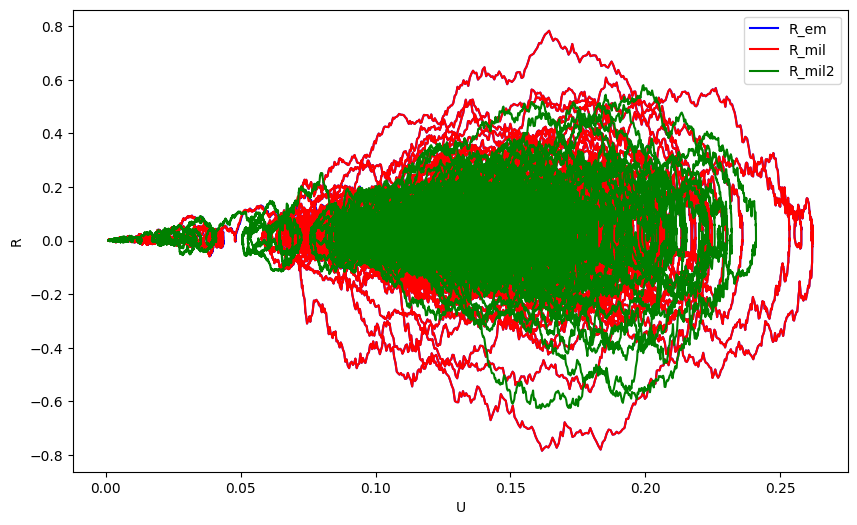

In [80]:
#plot U_em vs t_em
plt.figure(figsize=(10, 6))
plt.plot(U_em, R_em, 'b', label='R_em')
plt.plot(U_mil, R_mil, 'r', label='R_mil')
plt.plot(U_mil2, R_mil2, 'g', label='R_mil2')
plt.xlabel('U')
plt.ylabel('R')
plt.legend(loc='best')
plt.show()


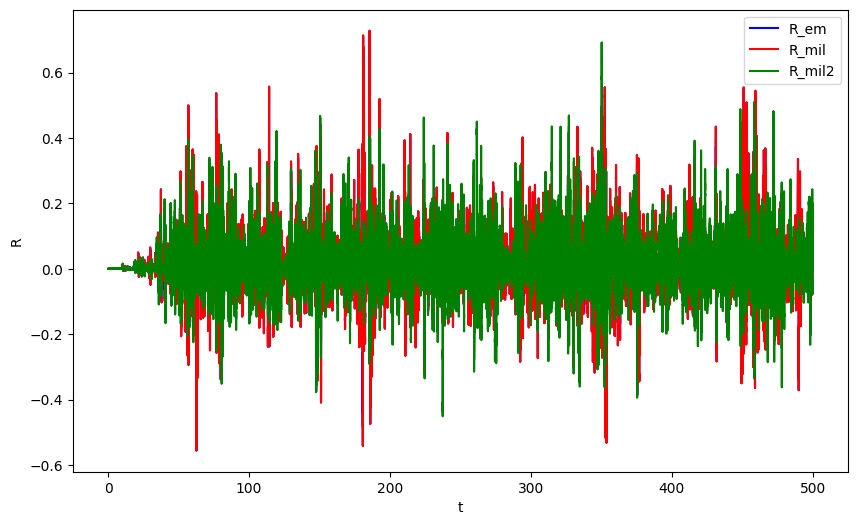

In [59]:
#plot U_em vs t_em
plt.figure(figsize=(10, 6))
plt.plot(t_em, R_em, 'b', label='R_em')
plt.plot(t_mil, R_mil, 'r', label='R_mil')
plt.plot(t_mil2, R_mil2, 'g', label='R_mil2')
# make a similar plot with more transparent lines
plt.xlabel('t')
plt.ylabel('R')
plt.legend(loc='best')
plt.show()


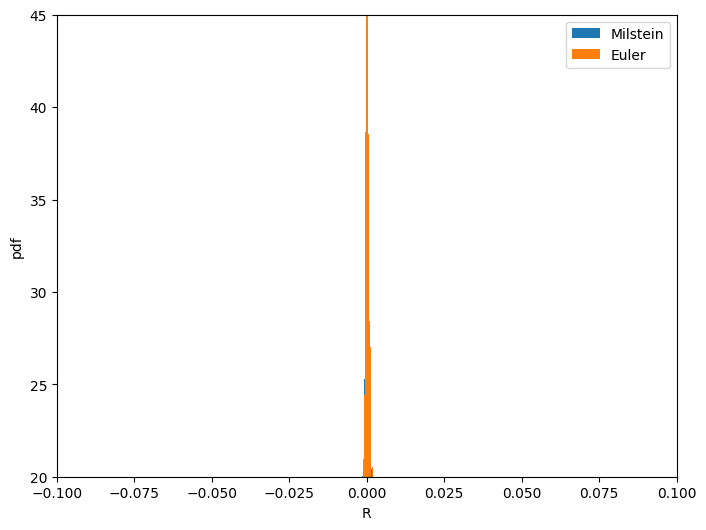

In [60]:
# plot the pdf of R
plt.figure(figsize=(8, 6))
plt.hist(R_mil, bins=10000, density=True, label='Milstein')
plt.hist(R_em, bins=10000, density=True, label='Euler')
# plt.hist(R_mil2, bins=10000, density=True, label='Milstein(dt/2)')
plt.xlabel('R')
plt.ylabel('pdf')
plt.xlim(-0.1, 0.1)
plt.ylim(20, 45)
plt.legend()
plt.show()

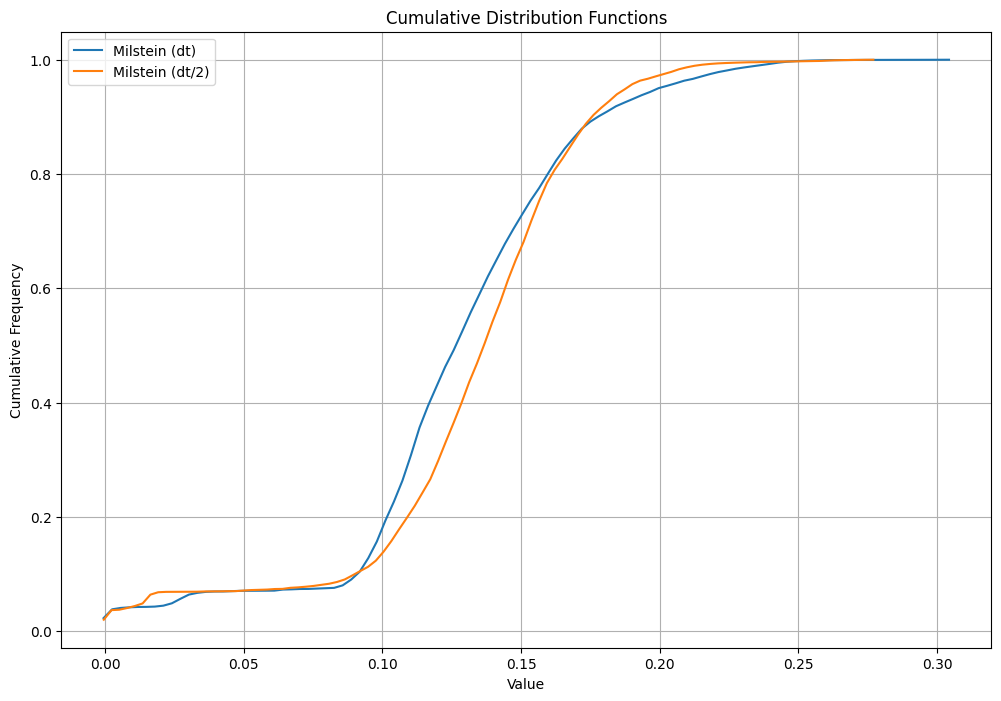

In [63]:
from scipy.stats import cumfreq

# Compute cumulative frequencies of the outputs
a_mil = cumfreq(y_mil[-1], numbins=100)
a_mil2 = cumfreq(y_mil2[-1], numbins=100)

# Plot CDFs
plt.figure(figsize=(12,8))
plt.plot(a_mil.lowerlimit + np.linspace(0, a_mil.binsize*a_mil.cumcount.size, a_mil.cumcount.size), a_mil.cumcount / y_mil[-1].size, label='Milstein (dt)')
plt.plot(a_mil2.lowerlimit + np.linspace(0, a_mil2.binsize*a_mil2.cumcount.size, a_mil2.cumcount.size), a_mil2.cumcount / y_mil2[-1].size, label='Milstein (dt/2)')
plt.title('Cumulative Distribution Functions')
plt.xlabel('Value')
plt.ylabel('Cumulative Frequency')
plt.legend()
plt.grid()
plt.show()

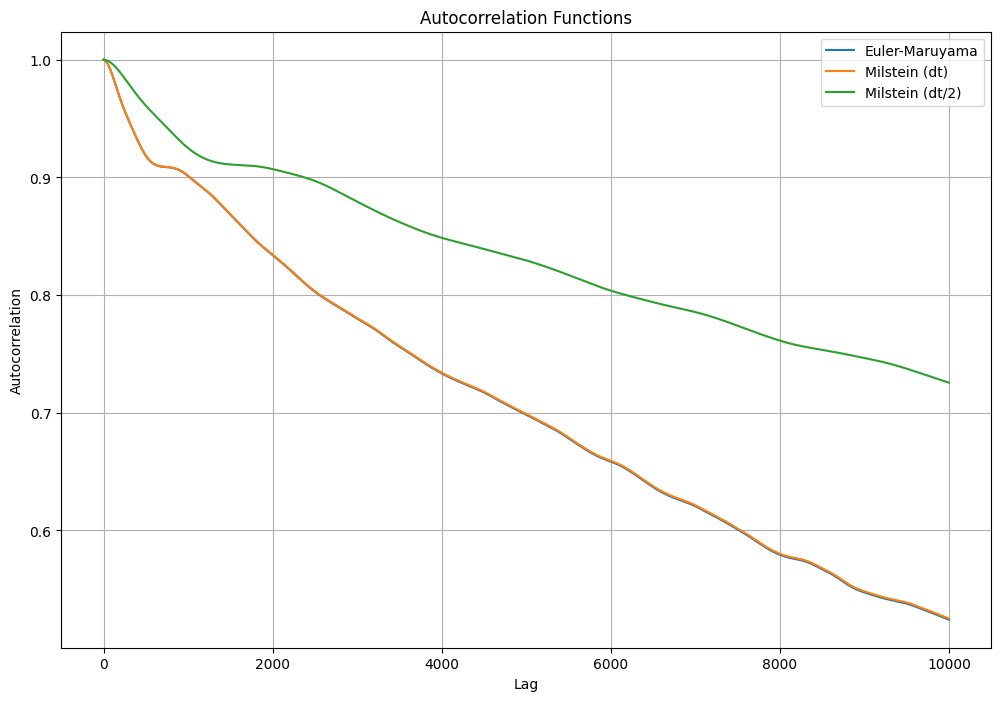

In [67]:
from statsmodels.tsa.stattools import acf

# Compute autocorrelation functions
acf_em = acf(y_em[-1], nlags=10000)
acf_mil = acf(y_mil[-1], nlags=10000)
acf_mil2 = acf(y_mil2[-1], nlags=10000)

# Plot autocorrelation functions
plt.figure(figsize=(12,8))
plt.plot(acf_em, label='Euler-Maruyama')
plt.plot(acf_mil, label='Milstein (dt)')
plt.plot(acf_mil2, label='Milstein (dt/2)')
plt.title('Autocorrelation Functions')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.legend()
plt.grid()
plt.show()

In [3]:
def autocorrelation_fft(data):
    data = data - np.mean(data)  # Remove the mean
    n = len(data)
    
    # Compute the power spectral density (PSD)
    data_fft = np.fft.fft(data, n=2*n)  # Zero-padding for avoiding circular convolution
    psd = np.abs(data_fft)**2
    
    # Compute the inverse Fourier transform of the PSD
    autocorr = np.fft.ifft(psd)
    
    # Keep only the positive lags and normalize the result
    autocorr = autocorr[:n].real
    autocorr /= autocorr[0]

    return autocorr

In [13]:
## The code below is used to generate the training data for the neural network

t_span = (0, 21000) # Time span
dt = 0.001  # Time step

t, y = euler_maruyama(initial_state, t_span, dt, epsilon)   # Solve the SDE
R = 0.25 * k * (k_plus**2 - k_e**2) * y[0] * y[2] 

# Extract the desired values
U = y[4]  # Extract U values
psi_e = y[0]  # Extract psi_e values
psi_p = y[2]  # Extract psi_p values

# Find the index corresponding to time t=100
start_index = int(100 / dt) 

# Slice arrays starting from the index of t=100
t = t[start_index:]
t = t - t[0]
y = y[:, start_index:]
U = U[start_index:]
R = R[start_index:]
psi_e = psi_e[start_index:]
psi_p = psi_p[start_index:]

In [21]:
# # Create a DataFrame with U and R
# df = pd.DataFrame({'U': U, 'R': R, 'psi_e': psi_e, 'psi_p': psi_p})
# df.to_csv('./data/train_data_longtime.csv', index=False) #save the dataframe as a csv file

# # save the variables t and y as a numpy array
# np.savez('./data/train_data_numpy_longtime.npz', t=t, y=y, t_slice=t_slice, y_slice=y_slice)

In [4]:
# load the variables t and y from the numpy file
data = np.load('./data/train_data_numpy_longtime.npz')
t = data['t_slice']
y = data['y_slice']
U = y[4]  # Extract U values
R = 0.25 * k * (k_plus**2 - k_e**2) * y[0] * y[2]

In [5]:
# subsample the rows with a step size of 8500
t = t[::8500]
U = U[::8500]
R = R[::8500]

# From the data created by the simulation, we calculate the conditional probability P(R|U) using a 2D histogram

In [5]:
# Define the number of bins
num_bins = 10

# Define the bins for U
u_bins = np.linspace(U.min(), U.max(), num_bins)

r_bins = np.linspace(R.min(), -R.min(), 50)

# Compute the 2D histogram of R and U
hist, u_edges, r_edges = np.histogram2d(U, R, bins=[u_bins, r_bins], density=True)

# Compute the conditional probability P(R|U) by normalizing each U bin by its total count
p_r_given_u = hist / np.sum(hist, axis=1, keepdims=True)


In [6]:
output_val = np.zeros(len(U))

del_R = r_bins[1] - r_bins[0]

# loop over the length of U:
for i in range(len(U)):
    # Find the index of the U bin that U[i] belongs to
    u_index = np.digitize(U[i], u_bins) - 1
    
    # Find the index of the R bin that R[i] belongs to
    r_index = np.digitize(R[i], r_bins) - 1

    if u_index == 9:
        u_index = 8
    if r_index == 49:
        r_index = 48
    # display a visible bar with the progress percentage
    if i % 100000 == 0:
        print(f'{i/len(U)*100:.2f}%')

    output_val[i] = p_r_given_u[u_index, r_index] / del_R


0.00%
0.48%
0.96%
1.44%
1.91%
2.39%
2.87%
3.35%
3.83%
4.31%
4.78%
5.26%
5.74%
6.22%
6.70%
7.18%
7.66%
8.13%
8.61%
9.09%
9.57%
10.05%
10.53%
11.00%
11.48%
11.96%
12.44%
12.92%
13.40%
13.88%
14.35%
14.83%
15.31%
15.79%
16.27%
16.75%
17.22%
17.70%
18.18%
18.66%
19.14%
19.62%
20.10%
20.57%
21.05%
21.53%
22.01%
22.49%
22.97%
23.44%
23.92%
24.40%
24.88%
25.36%
25.84%
26.32%
26.79%
27.27%
27.75%
28.23%
28.71%
29.19%
29.67%
30.14%
30.62%
31.10%
31.58%
32.06%
32.54%
33.01%
33.49%
33.97%
34.45%
34.93%
35.41%
35.89%
36.36%
36.84%
37.32%
37.80%
38.28%
38.76%
39.23%
39.71%
40.19%
40.67%
41.15%
41.63%
42.11%
42.58%
43.06%
43.54%
44.02%
44.50%
44.98%
45.45%
45.93%
46.41%
46.89%
47.37%
47.85%
48.33%
48.80%
49.28%
49.76%
50.24%
50.72%
51.20%
51.67%
52.15%
52.63%
53.11%
53.59%
54.07%
54.55%
55.02%
55.50%
55.98%
56.46%
56.94%
57.42%
57.89%
58.37%
58.85%
59.33%
59.81%
60.29%
60.77%
61.24%
61.72%
62.20%
62.68%
63.16%
63.64%
64.11%
64.59%
65.07%
65.55%
66.03%
66.51%
66.99%
67.46%
67.94%
68.42%
68.90%
69.38%

In [8]:
df = pd.DataFrame({'U': U, 'R': R, 'output': output_val})

In [9]:
# Calculate autocorrelation functions for U and R
U_autocorr = autocorrelation_fft(U)
# Add autocorrelation of U to the DataFrame
df['U_autocorr'] = U_autocorr

# moving average of U (window size 1000)
df['mov_avg2'] = df['U'].rolling(1000).mean()

# moving average of U (window size 10000)
df['mov_avg3'] = df['U'].rolling(10000).mean()

df = df.dropna() #drop the rows with NaN values

df.to_csv('./data/train_data_histogram_morefeatures.csv', index=False) #save the dataframe as a csv file

In [7]:
output_val = np.zeros(len(U))

del_R = r_bins[1] - r_bins[0]

# loop over the length of U:
for i in range(len(U)):
    # Find the index of the U bin that U[i] belongs to
    u_index = np.digitize(U[i], u_bins) - 1
    
    # Find the index of the R bin that R[i] belongs to
    r_index = np.digitize(R[i], r_bins) - 1

    if u_index == 9:
        u_index = 8
    if r_index == 49:
        r_index = 48
    # print out a percentage of the progress
    if i % 100000 == 0:
        print(f'{i/len(U)*100:.2f}%')

    # Compute the 2D histogram of R and U
    hist, u_edges, r_edges = np.histogram2d(U, R, bins=[u_bins, r_bins], density=True)

    # Compute the conditional probability P(R|U) by normalizing each U bin by its total count
    p_r_given_u = hist / np.sum(hist, axis=1, keepdims=True)

    output_val[i] = p_r_given_u[u_index, r_index] / del_R

In [8]:
df = pd.DataFrame({'U': U, 'R': R, 'output': output_val})
df.to_csv('./data/train_data_histogram_subsampled.csv', index=False) #save the dataframe as a csv file


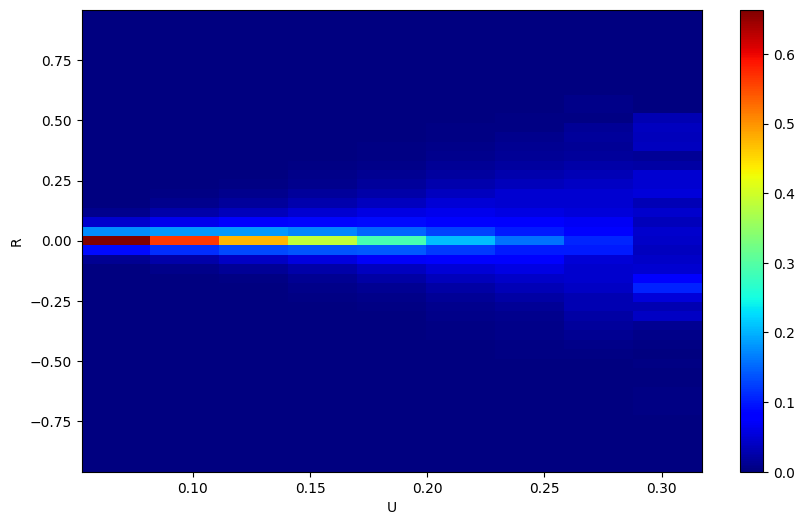

In [21]:
# plot the histogram
plt.figure(figsize=(10, 6))
plt.pcolormesh(u_bins, r_bins, p_r_given_u.T, cmap='jet')
plt.xlabel('U')
plt.ylabel('R')
plt.colorbar()
plt.show()


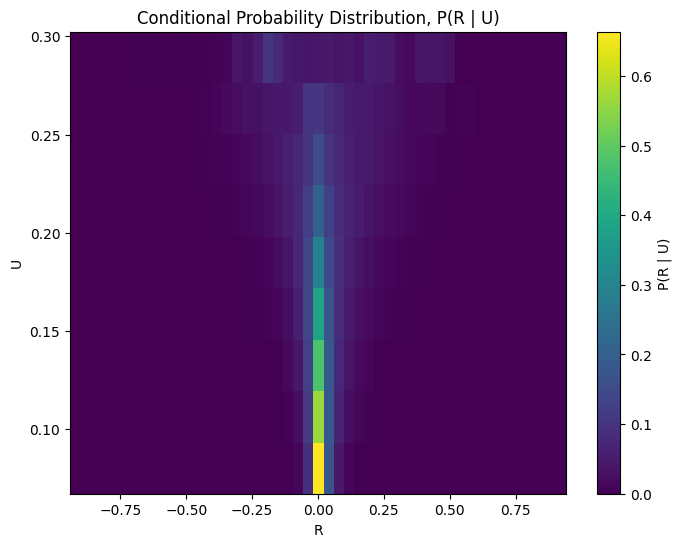

In [61]:
# Plot the conditional probability distribution, P(R|U)
plt.figure(figsize=(8, 6))

# Define the center of the bins
u_bin_centers = 0.5 * (u_bins[1:] + u_bins[:-1])
r_bin_centers = 0.5 * (r_edges[1:] + r_edges[:-1])

# Use imshow to make the 2D plot
plt.imshow(p_r_given_u, extent=[r_bin_centers.min(), r_bin_centers.max(), u_bin_centers.min(), u_bin_centers.max()], origin='lower', aspect='auto')

# Add a colorbar
plt.colorbar(label='P(R | U)')

# Set the labels
plt.xlabel('R')
plt.ylabel('U')

# Set the title
plt.title('Conditional Probability Distribution, P(R | U)')

# Show the plot
plt.show()

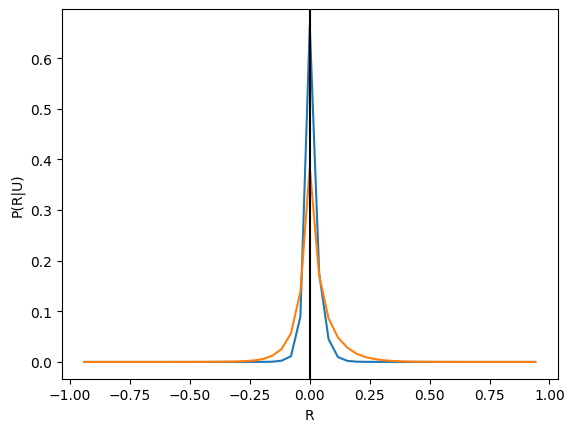

In [66]:
plt.plot(r_bin_centers, p_r_given_u[0,:])
plt.plot(r_bin_centers, p_r_given_u[3,:])
plt.axvline(x=0, color='k')
plt.xlabel('R')
plt.ylabel('P(R|U)')
# plt.legend(['U = 0.0', 'U = 0.3'])
plt.show()

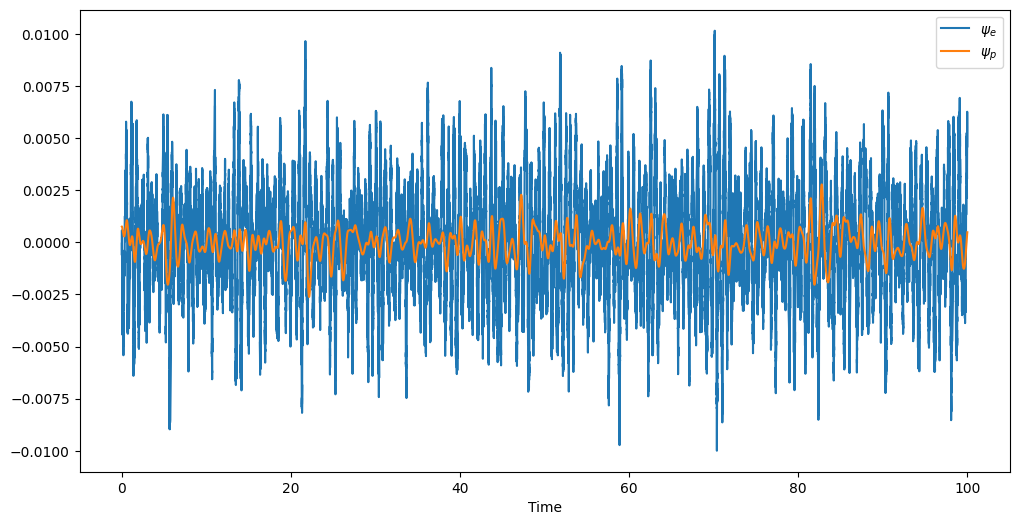

In [72]:
# Plot psie_e and psie_p against time
plt.figure(figsize=(12, 6))
plt.plot(t[0:int(100/0.001)], psi_e[0:int(100/0.001)], label='$\psi_e$')
plt.plot(t[0:int(100/0.001)], psi_p[0:int(100/0.001)], label='$\psi_p$')

plt.xlabel('Time')

plt.legend()
plt.show()


In [78]:
# Define the number of bins
num_bins = 10

# Define the bins for U
u_bins = np.linspace(U.min(), U.max(), num_bins)

psi_e_bins = np.linspace(psi_e.min(), -psi_e.min(), 50)
psi_p_bins = np.linspace(psi_p.min(), -psi_p.min(), 50)

# Compute the 2D histogram of R and U
hist, u_edges, psi_e_edges = np.histogram2d(U, psi_e, bins=[u_bins, psi_e_bins], density=True)
hist_p, u_edges, psi_p_edges = np.histogram2d(U, psi_p, bins=[u_bins, psi_p_bins], density=True)

# Compute the conditional probability P(R|U) by normalizing each U bin by its total count
p_psi_e_given_u = hist / np.sum(hist, axis=1, keepdims=True)
p_psi_p_given_u = hist_p / np.sum(hist_p, axis=1, keepdims=True)


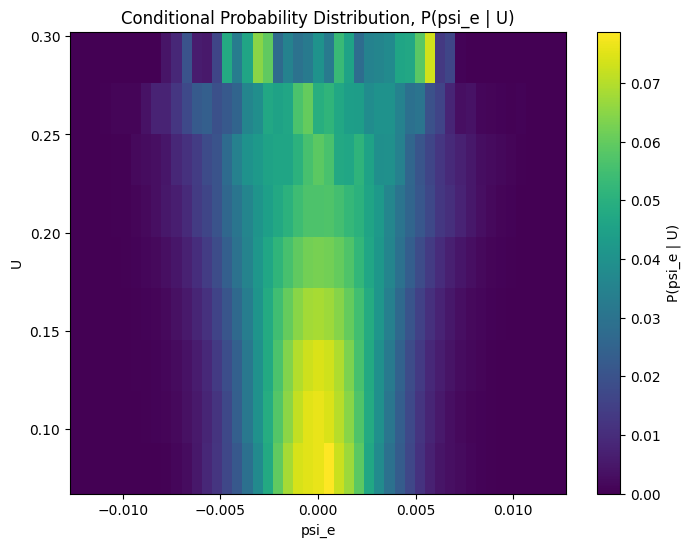

In [79]:
# Plot the conditional probability distribution, P(R|U)
plt.figure(figsize=(8, 6))

# Define the center of the bins
u_bin_centers = 0.5 * (u_bins[1:] + u_bins[:-1])
psi_e_bin_centers = 0.5 * (psi_e_edges[1:] + psi_e_edges[:-1])

# Use imshow to make the 2D plot
plt.imshow(p_psi_e_given_u, extent=[psi_e_bin_centers.min(), psi_e_bin_centers.max(), u_bin_centers.min(), u_bin_centers.max()], origin='lower', aspect='auto')

# Add a colorbar
plt.colorbar(label='P(psi_e | U)')

# Set the labels
plt.xlabel('psi_e')
plt.ylabel('U')

# Set the title
plt.title('Conditional Probability Distribution, P(psi_e | U)')

# Show the plot
plt.show()

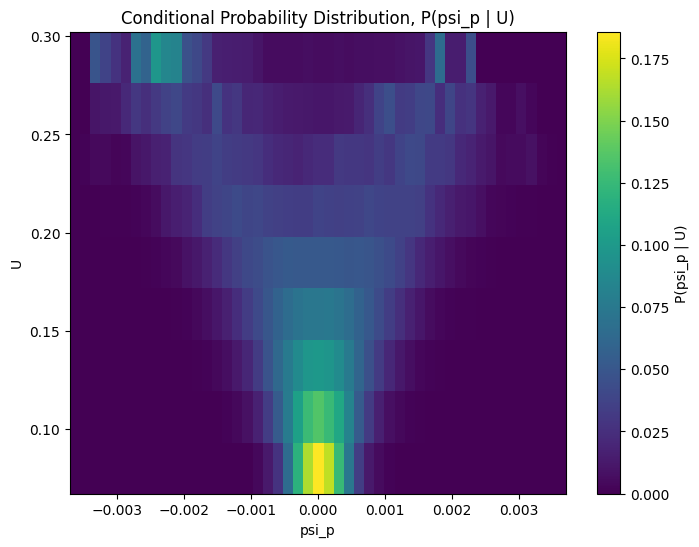

In [81]:
# Plot the conditional probability distribution, P(R|U)
plt.figure(figsize=(8, 6))

# Define the center of the bins
u_bin_centers = 0.5 * (u_bins[1:] + u_bins[:-1])
psi_p_bin_centers = 0.5 * (psi_p_edges[1:] + psi_p_edges[:-1])

# Use imshow to make the 2D plot
plt.imshow(p_psi_p_given_u, extent=[psi_p_bin_centers.min(), psi_p_bin_centers.max(), u_bin_centers.min(), u_bin_centers.max()], origin='lower', aspect='auto')

# Add a colorbar
plt.colorbar(label='P(psi_p | U)')

# Set the labels
plt.xlabel('psi_p')
plt.ylabel('U')

# Set the title
plt.title('Conditional Probability Distribution, P(psi_p | U)')

# Show the plot
plt.show()

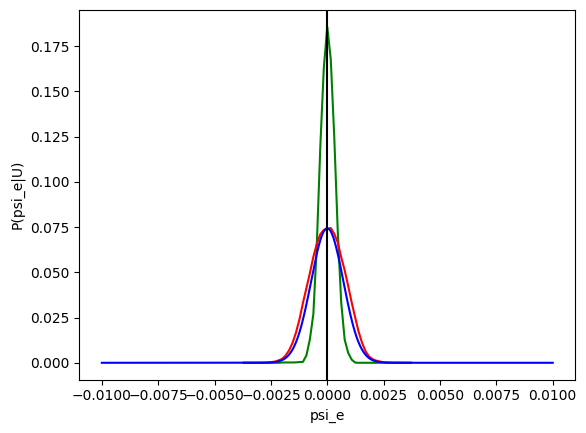

In [115]:
plt.plot(psi_p_bin_centers, p_psi_p_given_u[0,:],'g')
plt.plot(psi_p_bin_centers, p_psi_p_given_u[3,:],'r' )
plt.plot(x, y/7500, 'b')
plt.axvline(x=0, color='k')
plt.xlabel('psi_e')
plt.ylabel('P(psi_e|U)')
# plt.legend(['U = 0.0', 'U = 0.3'])
plt.show()

In [86]:
mean_psi_e = np.mean(psi_e)
mean_psi_p = np.mean(psi_p)
print(mean_psi_e)
print(mean_psi_p)

var_psi_e = np.var(psi_e)
var_psi_p = np.var(psi_p)
print(var_psi_e)
print(var_psi_p)

4.1714860188498506e-07
-1.0296962535920914e-06
8.697347204370003e-06
5.117092662040795e-07


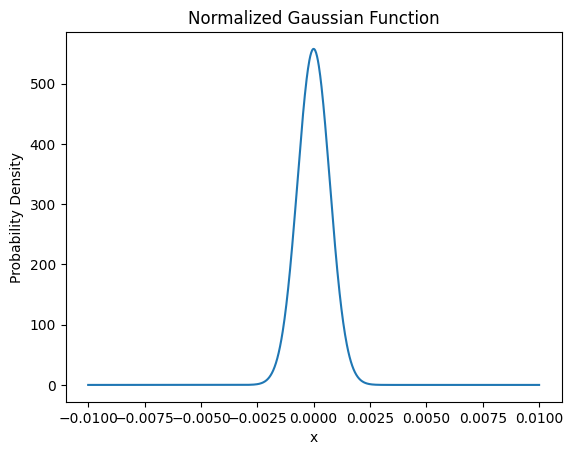

In [126]:
def gaussian(x, mean, variance):
    return (1. / np.sqrt(2*np.pi*variance)) * np.exp(-((x - mean)**2 / (2*variance)))

# Define parameters
mean = mean_psi_p
variance = var_psi_p
x = np.linspace(-0.01, 0.01, 1000)

# Generate Gaussian function
y = gaussian(x, mean, variance)

# Plot
plt.plot(x, y)
plt.title('Normalized Gaussian Function')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.show()

Text(0.5, 1.0, 'Distribution of Y')

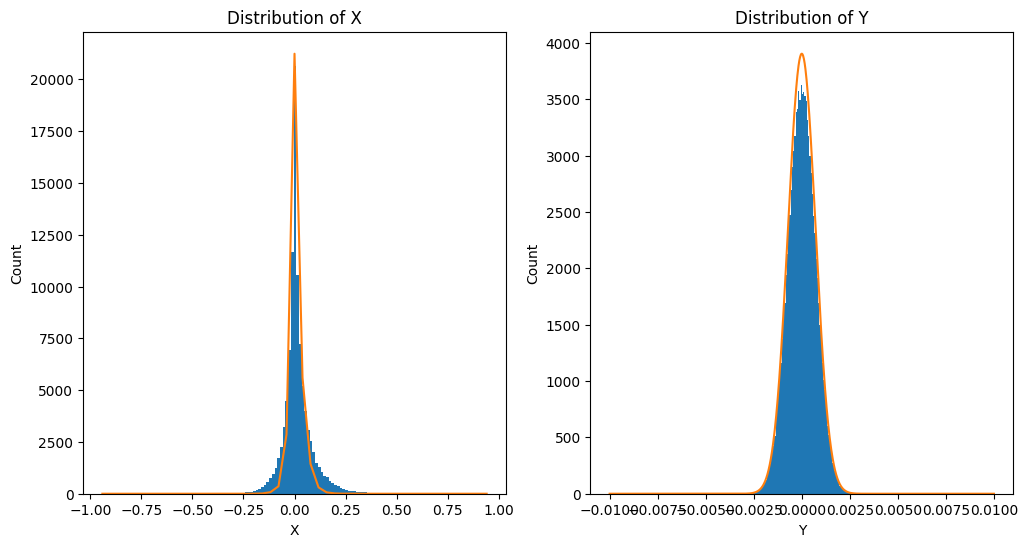

In [144]:
# Define means, variances, and covariance
mean_X = 0
mean_Y = 0
variance_X = var_psi_e
variance_Y = var_psi_p
covariance_XY = 4.07821003e-07  # Covariance between X and Y

# Define mean vector and covariance matrix
mean = [mean_X, mean_Y]
cov = [[variance_X, covariance_XY], [covariance_XY, variance_Y]]

# Generate random data
num_samples = 100000
X, Y = np.random.multivariate_normal(mean, cov, num_samples).T

# plot the distributions of X and Y
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(X*Y*0.25 * k * (k_plus**2 - k_e**2), bins=100)
plt.plot(r_bin_centers, p_r_given_u[0,:]*32000)
plt.xlabel('X')
plt.ylabel('Count')
plt.title('Distribution of X')

plt.subplot(1, 2, 2)
plt.hist(Y, bins=100)
plt.plot(x, y*7)
plt.xlabel('Y')
plt.ylabel('Count')
plt.title('Distribution of Y')


In [32]:
# Calculate autocorrelation functions for U and R
U_autocorr = autocorrelation_fft(U)

In [33]:
#Replace df['R'] with Rolling mean of R with window size 1000
df['R'] = df['R'].rolling(1000).mean()

# Add autocorrelation of U to the DataFrame
df['U_autocorr'] = U_autocorr

# moving average of U (window size 100)
df['mov_avg'] = df['U'].rolling(100).mean()

# moving average of U (window size 1000)
df['mov_avg2'] = df['U'].rolling(1000).mean()

# moving average of U (window size 10000)
df['mov_avg3'] = df['U'].rolling(10000).mean()

df = df.dropna() #drop the rows with NaN values

df.to_csv('./data/train_data_Uautocorr_longtime.csv', index=False) #save the dataframe as a csv file


In [34]:
#From the df dataframe, subsample the rows with a step size of 8500 and save it as a new dataframe and then save it as a csv file
df2 = df.iloc[::8500, :]
df2.to_csv('./data/train_data_subsampled_Uautocorr_longtime.csv', index=False)

In [25]:
#display nan values
print(df.isnull().sum())

U                  0
R                  0
std               99
std2             999
var               99
var2             999
mov_avg           99
mov_avg2         999
mov_avg3        9999
exp_mov_avg        0
exp_mov_avg2       0
detrend1          99
detrend2         999
detrend3        9999
dtype: int64


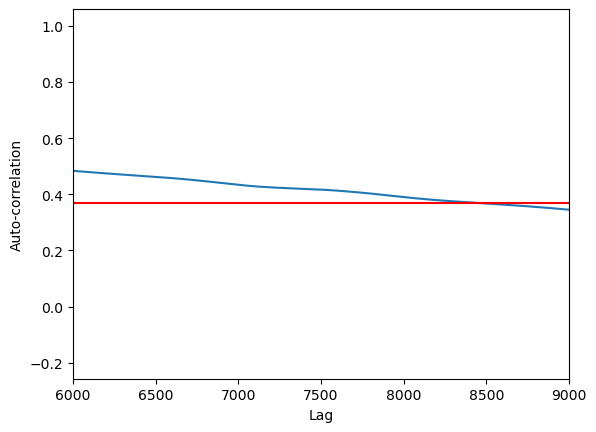

In [8]:
# Calculate U'
U_prime = U - np.mean(U)

# Compute the correlation with FFT
U_prime_fft = np.fft.fft(U_prime)
U_prime_fft = np.abs(U_prime_fft) ** 2
U_prime_fft = np.fft.ifft(U_prime_fft)
U_prime_fft = np.real(U_prime_fft)

# Extract the positive lags
U_prime_fft = U_prime_fft[:len(U_prime_fft) // 2]

# Normalize the auto-correlation function
U_prime_fft = U_prime_fft / U_prime_fft[0]

# Plot the auto-correlation function
plt.plot(U_prime_fft)
plt.xlabel('Lag')
plt.ylabel('Auto-correlation')
#plt.xlim(6000,9000)
plt.axhline(y=1/np.e, color='r', linestyle='-')
plt.show()

In [4]:
data = pd.read_csv('./data/train_data_Uautocorr_longtime.csv')

df = data.drop(['psi_e','psi_p'], axis=1)

In [6]:
df2 = df.iloc[::10, :]
df2.to_csv('./data/train_data_coursegrained_Uautocorr_longtime.csv', index=False)